### ReAct Agent Architecture...

In [1]:
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph.message import add_messages      ## Reducer

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(max_results=2)

In [5]:
tavily.invoke("What is Agentic AI?")

{'query': 'What is Agentic AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Agentic_AI',
   'title': 'Agentic AI - Wikipedia',
   'content': 'Agentic AI - Wikipedia Agentic AI **Agentic AI** is a class of artificial intelligence that focuses on autonomous systems that can make decisions and perform tasks without human intervention. The core concept of agentic AI is the use of _AI agents_ to perform automated tasks but without human intervention. Further, multimodal learning enable AI agents to integrate various types of information, such as text, images, audio and video . Breakthroughs in deep learning, reinforcement learning, and neural networks allowed AI systems to learn on their own and make decision with minimal human guidance._[citation needed_] Consilience of agentic AI across autonomous transportation, industrial automation, and tailored healthcare has also supported its viability. ^ Jump up to: _**a**__**b*

In [6]:
# My Custom Tool -> It's Not any Thing Special, Just a Python Function

def multiply(a:int, b:int) -> int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a * b

In [7]:
tools = [tavily, multiply]

In [8]:
from langchain_groq import ChatGroq

llm_with_tools = ChatGroq(model="llama-3.3-70b-versatile").bind_tools(tools=tools)

In [9]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002E613D43230>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002E614E66660>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [11]:
## Node Defination
def tool_calling_llm(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

In [12]:
## Initialize The State Graph
graph_builder = StateGraph(State)

In [13]:
## Add The Required Nodes
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [14]:
## Add The Needed Edges
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
graph_builder.add_edge("tools", "tool_calling_llm")

In [15]:
## Let's Compile The Graph
graph = graph_builder.compile()

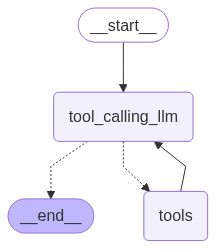

In [16]:
## Display The Graph
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({
    "messages": "What is the latest news about Reinforcement Learning?"
})

{'messages': [HumanMessage(content='What is the latest news about Reinforcement Learning?', additional_kwargs={}, response_metadata={}, id='12d27965-f0bc-4d3c-b057-52e5ee890bfa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cad2w30a0', 'function': {'arguments': '{"query":"latest news Reinforcement Learning","search_depth":"advanced","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1859, 'total_tokens': 1892, 'completion_time': 0.076393624, 'prompt_time': 0.14247717, 'queue_time': 0.08815417800000003, 'total_time': 0.218870794}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9ba437ac-3bc1-4c7e-b723-578b68df4ad0-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'latest news Reinforcement Learning', 'search_depth': 'advanced', 'topic': 'gener

In [18]:
response = graph.invoke({
    "messages": "What is the latest news about Reinforcement Learning?"
})

response["messages"][-1].content

'The latest news about Reinforcement Learning is that the market is expected to grow from $10.49 billion in 2024 to $13.52 billion in 2025, with a compound annual growth rate (CAGR) of 28.9%. Additionally, there are new developments in the field, such as reflective prompt evolution, which can outperform reinforcement learning in certain tasks.'

In [19]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (f62k2bwhc)
 Call ID: f62k2bwhc
  Args:
    query: latest news Reinforcement Learning
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.openpr.com/news/4127549/future-of-the-reinforcement-learning-market-trends", "title": "Future of the Reinforcement Learning Market: Trends, - openPR.com", "content": "Moving from $10.49 billion in 2024, the market is slated to reach $13.52 billion in 2025, witnessing a compound annual growth rate (CAGR) of 28.9%.", "score": 0.55362654, "raw_content": null}, {"url": "https://news.ycombi

In [20]:
response = graph.invoke({
    "messages": "Multiply 51 and 6"
})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Multiply 51 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (rveecdnxn)
 Call ID: rveecdnxn
  Args:
    a: 51
    b: 6
================================= Tool Message =================================
Name: multiply

306
================================== Ai Message ==================================

The result of multiplying 51 and 6 is 306.


In [21]:
response = graph.invoke({
    "messages": "What is the latest news about Reinforcement Learning and then Multiply 51 by 6??"
})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning and then Multiply 51 by 6??
================================== Ai Message ==================================
Tool Calls:
  tavily_search (v0y8w1gj5)
 Call ID: v0y8w1gj5
  Args:
    query: latest news Reinforcement Learning
    search_depth: advanced
    topic: general
  multiply (5vx8gb504)
 Call ID: 5vx8gb504
  Args:
    a: 51
    b: 6
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/@fahey_james/the-state-of-reinforcement-learning-in-2025-foundations-frontiers-and-future-applications-c81ae556fc8a", "title": "The State of Reinforcement Learning in 2025: Foundations ...", "content": "Reinforcement learning in 2025 remains both promising and limited. It domi